In [7]:
import sys
sys.path.append("../../../")

## 数据

In [8]:
from pylib.utils.functions_for_classification import mixed_2d_2cls, plot_scatter
import matplotlib.pyplot as plt

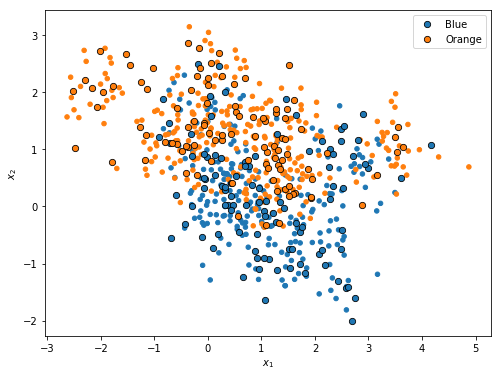

In [9]:
X_train, X_test, y_train, y_test = mixed_2d_2cls()
plt.figure(figsize=(8, 6))
plot_scatter(X_train, y_train, X_test, y_test)
plt.show()

## Logit 提升

In [10]:
from pylib.utils.functions_for_classification import plot_decision_boundary
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeRegressor
from copy import deepcopy
import numpy as np

In [11]:
class LogitBoost(BaseEstimator, ClassifierMixin):
    """
    Logit提升
    
    参数
    ----
    base_estimator: 基本学习器，一般使用简单的回归树
    n_estimators: 基本学习器的数量
    learning_rate: 每个基本学习器的权重，也叫学习率
    
    属性
    ----
    loss_history: 存储历史的损失值
    """
    def __init__(self, base_estimator=DecisionTreeRegressor(max_depth=3),
                 n_estimators=100, learning_rate=0.1):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
    
    # 对数损失函数
    def __logloss(self, y, y_proba):
        n = len(y)
        return np.sum([np.log(1 + np.exp(-y[i] * y_proba[i])) for i in range(n)])
    
    def fit(self, X, y):
        n = len(X)
        ym_pred = np.zeros(n, dtype=np.longdouble)
        ym_proba = 1. / (1 + np.exp(-2 * ym_pred))
        self.weights = []
        self.estimators = []
        self.loss_history = []
        tol = 1e-8
        for m in range(self.n_estimators):
            zm = (y - ym_proba) / ((ym_proba + tol) * (1 - ym_proba + tol))
            wm = ym_proba * (1 - ym_proba)
            base_learner = deepcopy(self.base_estimator)  # 用基本学习器加权拟合样本
            base_learner.fit(X, zm, sample_weight=wm)  
            ym_pred = ym_pred + self.learning_rate * base_learner.predict(X) #  更新
            ym_proba = 1. / (1 + np.exp(-2 * ym_pred))
            self.weights.append(wm)
            loss = self.__logloss(y, ym_proba)
            self.estimators.append(base_learner)
            self.loss_history.append(loss)
            
        return self
    
    def predict(self, X):
        ym_pred = 0
        for learner, w in zip(self.estimators, self.weights):
            ym_pred += self.learning_rate * learner.predict(X)  
        ym_pred = np.where(ym_pred > 0.5, 1, 0)
        
        return ym_pred

In [12]:
logitboost = LogitBoost()
logitboost.fit(X_train, y_train)

LogitBoost()

In [13]:
train_err = 1 - logitboost.score(X_train, y_train)
print("训练样本误差：{:.3f}".format(train_err))

训练样本误差：0.005


In [14]:
test_err = 1 - logitboost.score(X_test, y_test)
print("测试样本误差：{:.3f}".format(test_err))

测试样本误差：0.258


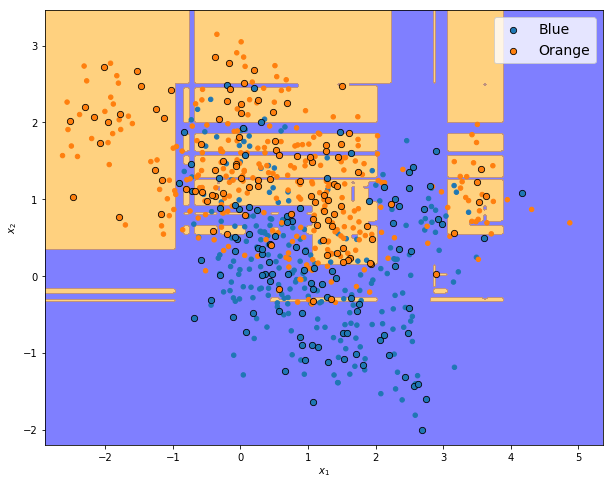

In [15]:
# 画出决策边界
plt.figure(figsize=(10, 8))
plot_decision_boundary(X_train, y_train, X_test, y_test, logitboost)
plt.show()

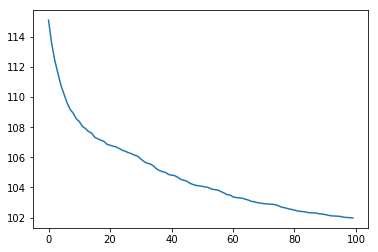

In [16]:
# 绘制历史损失值
loss_history = logitboost.loss_history
plt.plot(range(len(loss_history)), loss_history)
plt.show()

### 寻找最优参数

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
param_grid = {
    'base_estimator__max_depth': [3, 5, 10],
    'base_estimator__min_samples_leaf': [5, 10, 20, 30, 40],
    'n_estimators': [30, 50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0]
}
logitboost_cv = GridSearchCV(
    LogitBoost(base_estimator=DecisionTreeRegressor(random_state=42)),
    param_grid,
    cv=10,
    n_jobs=-1)
logitboost_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=LogitBoost(base_estimator=DecisionTreeRegressor(random_state=42)),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [3, 5, 10],
                         'base_estimator__min_samples_leaf': [5, 10, 20, 30,
                                                              40],
                         'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
                         'n_estimators': [30, 50, 100, 150]})

In [19]:
logitboost_cv.best_params_

{'base_estimator__max_depth': 5,
 'base_estimator__min_samples_leaf': 5,
 'learning_rate': 0.5,
 'n_estimators': 100}

### 使用最优参数模型

In [20]:
logitboost_best = logitboost_cv.best_estimator_

In [21]:
train_err = 1 - logitboost_best.score(X_train, y_train)
print("训练样本误差: {:.3f}".format(train_err))

训练样本误差: 0.000


In [22]:
test_err = 1 - logitboost_best.score(X_test, y_test)
print("测试样本误差：{:.3f}".format(test_err))

测试样本误差：0.278


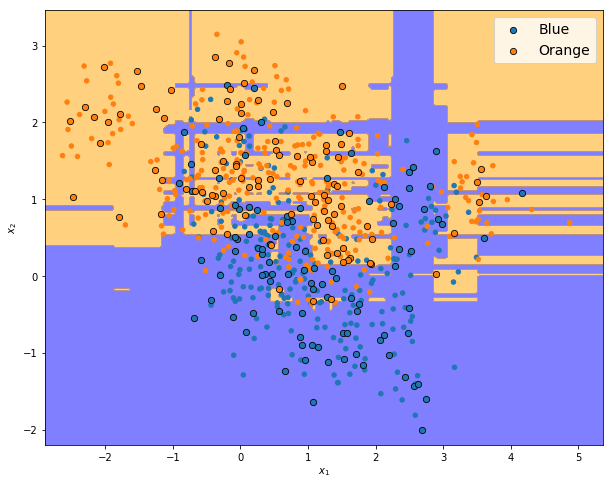

In [23]:
# 画出决策边界
plt.figure(figsize=(10, 8))
plot_decision_boundary(X_train, y_train, X_test, y_test, logitboost_best)
plt.show()

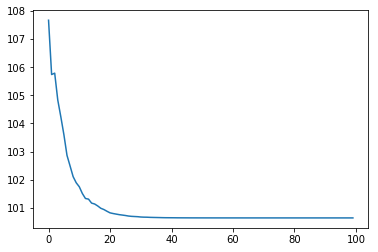

In [24]:
# 绘制历史损失值
loss_history = logitboost_best.loss_history
plt.plot(range(len(loss_history)), loss_history)
plt.show()